In [4]:
"""
data_prep.py

Simulate synthetic marketing data for:
- Marketing Mix Modeling (MMM)
- Clean-room–style analysis (join CRM + platform logs on user_id)
- Audience segmentation
- Simple MTA-style path analysis
- Media optimization

Outputs (saved under data/raw/):
- ad_spend_by_channel.csv
- daily_sales.csv
- user_events.csv
- crm_customers.csv
"""

import os
from datetime import datetime, timedelta

import numpy as np
import pandas as pd


# -----------------------------
# Global config
# -----------------------------

SEED = 42
np.random.seed(SEED)

N_DAYS = 180
START_DATE = datetime(2024, 1, 1)

CHANNELS = ["facebook", "search", "youtube", "email"]

# Base daily spend per channel (in dollars)
BASE_SPEND = {
    "facebook": 4000,
    "search": 5000,
    "youtube": 2500,
    "email": 500,
}

# Approximate CPMs (cost per 1000 impressions)
CPM = {
    "facebook": 8,
    "search": 10,
    "youtube": 6,
    "email": 4,
}

# Approximate click-through rates
CTR = {
    "facebook": 0.015,
    "search": 0.03,
    "youtube": 0.008,
    "email": 0.05,
}

# Approximate conversion rates (post-click)
CVR = {
    "facebook": 0.03,
    "search": 0.05,
    "youtube": 0.02,
    "email": 0.04,
}

AVG_ORDER_VALUE = 80.0  # dollars

# Number of additional non-converting users to simulate
NON_CONVERTING_USER_MULTIPLIER = 3


# -----------------------------
# Helper functions
# -----------------------------

def make_date_range(n_days: int, start_date: datetime) -> pd.DatetimeIndex:
    """Create a daily date range."""
    return pd.date_range(start=start_date, periods=n_days, freq="D")


def seasonality_factor(day_index: int) -> float:
    """
    Simple weekly seasonality:
    - weekends slightly higher demand
    """
    # day_index 0=Monday if we start Monday, but we'll just mod by 7
    dow = day_index % 7
    if dow in [5, 6]:  # Saturday, Sunday
        return 1.15
    elif dow in [0]:  # Monday slump
        return 0.9
    else:
        return 1.0


# -----------------------------
# 1. Simulate daily channel-level spend + performance
# -----------------------------

def simulate_channel_daily_data() -> pd.DataFrame:
    """
    Simulate daily spend, impressions, clicks, conversions by channel.

    Returns:
        DataFrame with columns:
            date, channel, spend, impressions, clicks, conversions
    """
    dates = make_date_range(N_DAYS, START_DATE)
    rows = []

    for day_idx, date in enumerate(dates):
        seas = seasonality_factor(day_idx)

        for ch in CHANNELS:
            base = BASE_SPEND[ch] * seas

            # Add some random noise, but keep spend positive
            spend = max(
                100.0,
                np.random.normal(loc=base, scale=0.15 * base)
            )

            # Impressions from spend and CPM
            impressions = int((spend / CPM[ch]) * 1000)

            # Clicks from impressions and CTR
            clicks = np.random.binomial(
                n=impressions,
                p=min(CTR[ch], 0.3),  # cap probabilities
            )

            # Conversions from clicks and CVR
            conversions = np.random.binomial(
                n=clicks,
                p=min(CVR[ch], 0.5),
            )

            rows.append({
                "date": date,
                "channel": ch,
                "spend": round(spend, 2),
                "impressions": impressions,
                "clicks": clicks,
                "conversions": conversions,
            })

    df = pd.DataFrame(rows)
    return df


# -----------------------------
# 2. Aggregate to daily sales
# -----------------------------

def build_daily_sales(ad_df: pd.DataFrame) -> pd.DataFrame:
    """
    Aggregate conversions to daily orders and revenue.

    Returns:
        DataFrame with columns:
            date, orders, revenue
    """
    daily = (
        ad_df.groupby("date", as_index=False)["conversions"]
        .sum()
        .rename(columns={"conversions": "orders"})
    )

    # Revenue with some noise around average order value
    noise = np.random.normal(loc=1.0, scale=0.05, size=len(daily))
    daily["revenue"] = (daily["orders"] * AVG_ORDER_VALUE * noise).round(2)

    return daily


# -----------------------------
# 3. Simulate user-level events (for paths / MTA / segmentation)
# -----------------------------

def simulate_user_paths(ad_df: pd.DataFrame) -> pd.DataFrame:
    """
    Create user-level event paths based on conversions per day+channel.

    For each conversion we create:
    - 1-3 pre-conversion events (impressions/clicks across channels)
    - 1 purchase event

    Additionally, we simulate non-converting users who have impressions/clicks
    but no purchase.

    Returns:
        DataFrame with columns:
            user_id, event_time, event_type, channel
    """
    events = []
    user_id_counter = 1

    # Convert date to pure date (no time) for easier handling
    ad_df = ad_df.copy()
    ad_df["date"] = pd.to_datetime(ad_df["date"])

    # Converting users
    for _, row in ad_df.iterrows():
        date = row["date"]
        ch = row["channel"]
        n_conv = int(row["conversions"])

        for _ in range(n_conv):
            uid = user_id_counter
            user_id_counter += 1

            # Number of pre-conversion touches
            n_pre = np.random.randint(1, 4)  # 1-3

            # Random lookback days (within last 7 days)
            for _ in range(n_pre):
                lookback = np.random.randint(1, 8)
                event_date = date - timedelta(days=lookback)
                pre_channel = np.random.choice(CHANNELS)

                evt_type = np.random.choice(["impression", "click"], p=[0.7, 0.3])

                events.append({
                    "user_id": uid,
                    "event_time": event_date + timedelta(
                        hours=np.random.randint(8, 22)
                    ),
                    "event_type": evt_type,
                    "channel": pre_channel,
                })

            # Purchase event
            events.append({
                "user_id": uid,
                "event_time": date + timedelta(
                    hours=np.random.randint(8, 22)
                ),
                "event_type": "purchase",
                "channel": ch,  # last-touch channel
            })

    n_converting_users = user_id_counter - 1

    # Non-converting users
    n_non_conv_users = NON_CONVERTING_USER_MULTIPLIER * n_converting_users

    for _ in range(n_non_conv_users):
        uid = user_id_counter
        user_id_counter += 1

        # choose a random date in the range
        day_offset = np.random.randint(0, N_DAYS)
        base_date = START_DATE + timedelta(days=day_offset)

        # 1–4 events
        n_evts = np.random.randint(1, 5)
        for _ in range(n_evts):
            offset = np.random.randint(0, 3)
            event_date = base_date + timedelta(days=offset)
            ch = np.random.choice(CHANNELS)
            evt_type = np.random.choice(["impression", "click"], p=[0.8, 0.2])

            events.append({
                "user_id": uid,
                "event_time": event_date + timedelta(
                    hours=np.random.randint(8, 22)
                ),
                "event_type": evt_type,
                "channel": ch,
            })

    events_df = pd.DataFrame(events)
    events_df.sort_values(["user_id", "event_time"], inplace=True)
    events_df.reset_index(drop=True, inplace=True)

    return events_df


# -----------------------------
# 4. CRM / customer table
# -----------------------------

def build_crm_table(events_df: pd.DataFrame) -> pd.DataFrame:
    """
    Build a CRM-like table with one row per user.

    For each user:
    - signup_date: first event_time
    - primary_channel: most frequent channel
    - region: random region
    - ltv_bucket: based on whether user purchased

    Returns:
        DataFrame with columns:
            user_id, signup_date, primary_channel, region, ltv_bucket
    """
    # First event per user
    first_events = (
        events_df.sort_values("event_time")
        .groupby("user_id", as_index=False)
        .first()[["user_id", "event_time", "channel"]]
    )
    first_events.rename(
        columns={"event_time": "signup_date", "channel": "first_channel"},
        inplace=True,
    )

    # Primary channel: most frequent channel per user
    channel_counts = (
        events_df.groupby(["user_id", "channel"])
        .size()
        .reset_index(name="cnt")
    )
    primary_ch = (
        channel_counts.sort_values(["user_id", "cnt"], ascending=[True, False])
        .drop_duplicates("user_id")[["user_id", "channel"]]
        .rename(columns={"channel": "primary_channel"})
    )

    crm = pd.merge(first_events, primary_ch, on="user_id", how="left")

    # Did user ever purchase?
    purchases = (
        events_df[events_df["event_type"] == "purchase"]
        .groupby("user_id")
        .size()
        .reset_index(name="n_purchases")
    )

    crm = pd.merge(crm, purchases, on="user_id", how="left")
    crm["n_purchases"] = crm["n_purchases"].fillna(0).astype(int)

    # Assign regions
    regions = ["NA", "EU", "APAC", "LATAM"]
    crm["region"] = np.random.choice(regions, size=len(crm), p=[0.5, 0.2, 0.2, 0.1])

    # LTV bucket based on purchases + random noise
    def assign_ltv(row):
        if row["n_purchases"] == 0:
            return "low"
        elif row["n_purchases"] == 1:
            return np.random.choice(["medium", "high"], p=[0.7, 0.3])
        else:
            return "high"

    crm["ltv_bucket"] = crm.apply(assign_ltv, axis=1)

    # Tidy columns
    crm["signup_date"] = pd.to_datetime(crm["signup_date"]).dt.date

    return crm[["user_id", "signup_date", "primary_channel", "region", "ltv_bucket"]]


# -----------------------------
# Main orchestration
# -----------------------------

def main():
    # Ensure output directory exists
    raw_dir = os.path.join("data", "raw")
    os.makedirs(raw_dir, exist_ok=True)

    # 1) Channel-level daily data
    ad_df = simulate_channel_daily_data()
    ad_path = os.path.join(raw_dir, "ad_spend_by_channel.csv")
    ad_df.to_csv(ad_path, index=False)
    print(f"Saved: {ad_path}")

    # 2) Daily sales
    sales_df = build_daily_sales(ad_df)
    sales_path = os.path.join(raw_dir, "daily_sales.csv")
    sales_df.to_csv(sales_path, index=False)
    print(f"Saved: {sales_path}")

    # 3) User-level events
    events_df = simulate_user_paths(ad_df)
    events_df["event_time"] = events_df["event_time"].dt.strftime("%Y-%m-%d %H:%M:%S")
    events_path = os.path.join(raw_dir, "user_events.csv")
    events_df.to_csv(events_path, index=False)
    print(f"Saved: {events_path}")

    # 4) CRM table
    crm_df = build_crm_table(events_df)
    crm_path = os.path.join(raw_dir, "crm_customers.csv")
    crm_df.to_csv(crm_path, index=False)
    print(f"Saved: {crm_path}")

    print("\nData simulation complete ✅")


if __name__ == "__main__":
    main()

Saved: data/raw/ad_spend_by_channel.csv
Saved: data/raw/daily_sales.csv
Saved: data/raw/user_events.csv
Saved: data/raw/crm_customers.csv

Data simulation complete ✅


**EDA**


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8")
sns.set_palette("deep")

raw_path = "data/raw/"

In [12]:
ad = pd.read_csv(raw_path + "ad_spend_by_channel.csv")
sales = pd.read_csv(raw_path + "daily_sales.csv")
events = pd.read_csv(raw_path + "user_events.csv")
crm = pd.read_csv(raw_path + "crm_customers.csv")

ad.head(), sales.head(), events.head(), crm.head()

(         date   channel    spend  impressions  clicks  conversions
 0  2024-01-01  facebook  3868.23       483528    7320          221
 1  2024-01-01    search  4406.67       440667   13027          658
 2  2024-01-01   youtube  2091.55       348592    2795           57
 3  2024-01-01     email   486.62       121655    6128          269
 4  2024-01-02  facebook  3455.19       431898    6448          188,
          date  orders    revenue
 0  2024-01-01    1205  103393.47
 1  2024-01-02    1104   96300.58
 2  2024-01-03    1088   79717.07
 3  2024-01-04    1406  106720.86
 4  2024-01-05    1289  101677.30,
    user_id           event_time  event_type   channel
 0        1  2023-12-28 17:00:00  impression  facebook
 1        1  2024-01-01 09:00:00    purchase  facebook
 2        2  2023-12-26 13:00:00  impression   youtube
 3        2  2024-01-01 13:00:00    purchase  facebook
 4        3  2023-12-29 10:00:00  impression    search,
    user_id signup_date primary_channel region ltv_buck

In [14]:
ad["date"] = pd.to_datetime(ad["date"])
sales["date"] = pd.to_datetime(sales["date"])
events["event_time"] = pd.to_datetime(events["event_time"])
crm["signup_date"] = pd.to_datetime(crm["signup_date"])

In [16]:
print("Ad rows:", len(ad))
print("Sales rows:", len(sales))
print("Events rows:", len(events))
print("CRM rows:", len(crm))

print("\nDate ranges:")
print("ad:", ad["date"].min(), "to", ad["date"].max())
print("sales:", sales["date"].min(), "to", sales["date"].max())
print("events:", events["event_time"].min(), "to", events["event_time"].max())
print("crm:", crm["signup_date"].min(), "to", crm["signup_date"].max())

Ad rows: 720
Sales rows: 180
Events rows: 2550171
CRM rows: 971384

Date ranges:
ad: 2024-01-01 00:00:00 to 2024-06-28 00:00:00
sales: 2024-01-01 00:00:00 to 2024-06-28 00:00:00
events: 2023-12-25 08:00:00 to 2024-06-30 21:00:00
crm: 2023-12-25 00:00:00 to 2024-06-30 00:00:00


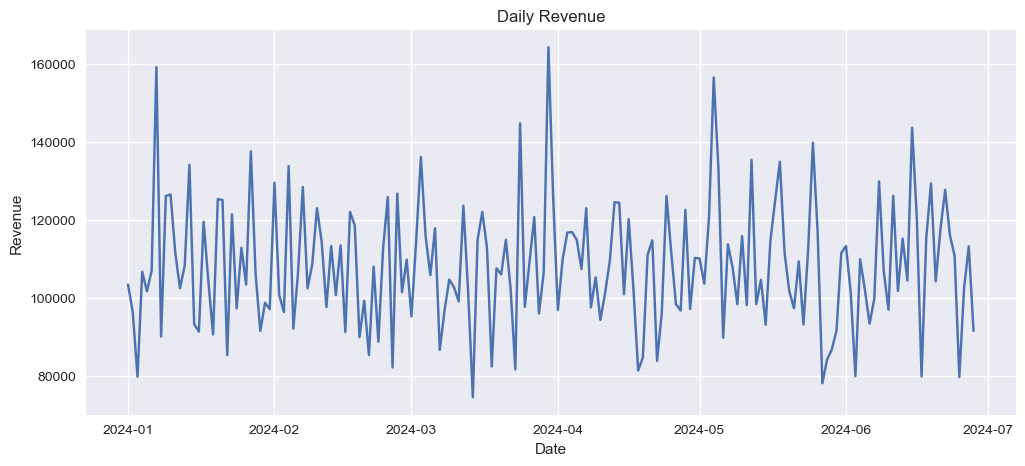

In [18]:
plt.figure(figsize=(12,5))
plt.plot(sales["date"], sales["revenue"])
plt.title("Daily Revenue")
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.show()

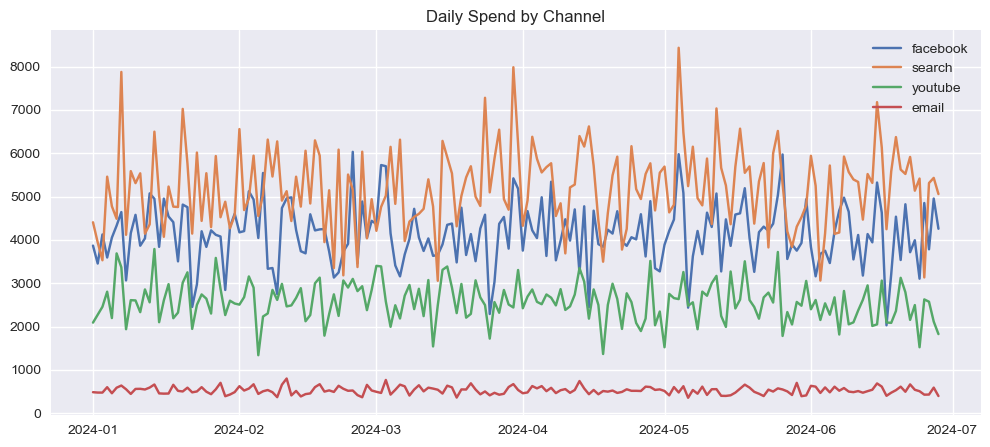

In [20]:
plt.figure(figsize=(12,5))
for ch in ad["channel"].unique():
    plt.plot(
        ad[ad["channel"] == ch]["date"],
        ad[ad["channel"] == ch]["spend"],
        label=ch
    )
plt.title("Daily Spend by Channel")
plt.legend()
plt.show()

In [22]:
conv_by_channel = ad.groupby("channel")["conversions"].sum().sort_values(ascending=False)
conv_by_channel


channel
search      140682
email        47534
facebook     42069
youtube      12561
Name: conversions, dtype: int64

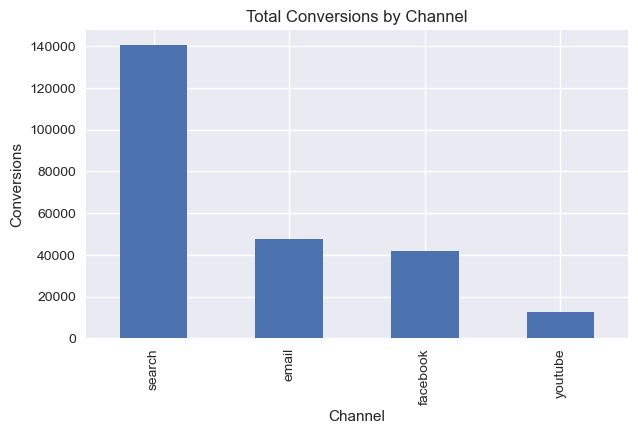

In [24]:
conv_by_channel.plot(kind="bar", figsize=(7,4))
plt.title("Total Conversions by Channel")
plt.xlabel("Channel")
plt.ylabel("Conversions")
plt.show()

In [26]:
events["event_type"].value_counts()

event_type
impression    1797512
click          509813
purchase       242846
Name: count, dtype: int64

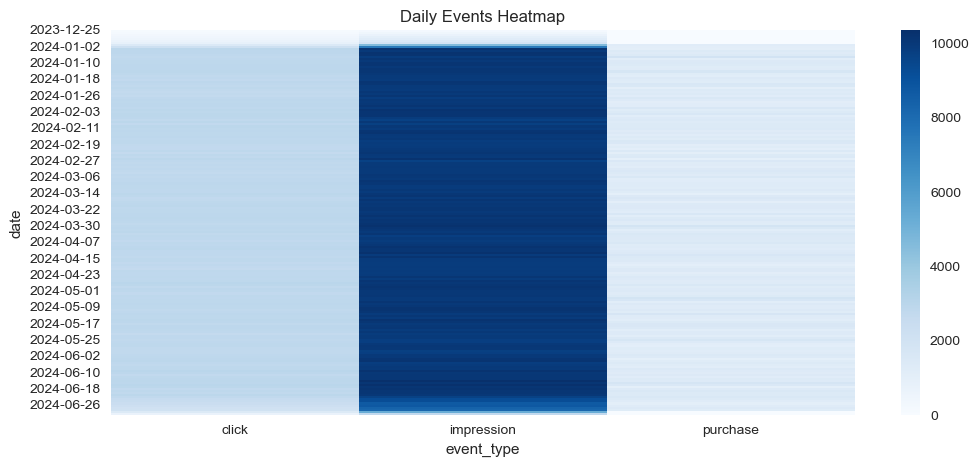

In [28]:
events["date"] = events["event_time"].dt.date
pivot = events.pivot_table(
    index="date",
    columns="event_type",
    values="user_id",
    aggfunc="count"
)

plt.figure(figsize=(12,5))
sns.heatmap(pivot.fillna(0), cmap="Blues")
plt.title("Daily Events Heatmap")
plt.show()

**Audience Segmentation**

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

plt.style.use("seaborn-v0_8")
sns.set_palette("deep")

raw_path = "data/raw/"

events = pd.read_csv(raw_path + "user_events.csv")
crm = pd.read_csv(raw_path + "crm_customers.csv")

events["event_time"] = pd.to_datetime(events["event_time"])
crm["signup_date"] = pd.to_datetime(crm["signup_date"])

In [38]:
events.head(), crm.head()

(   user_id          event_time  event_type   channel
 0        1 2023-12-28 17:00:00  impression  facebook
 1        1 2024-01-01 09:00:00    purchase  facebook
 2        2 2023-12-26 13:00:00  impression   youtube
 3        2 2024-01-01 13:00:00    purchase  facebook
 4        3 2023-12-29 10:00:00  impression    search,
    user_id signup_date primary_channel region ltv_bucket
 0        1  2023-12-28        facebook  LATAM     medium
 1        2  2023-12-26        facebook   APAC     medium
 2        3  2023-12-29        facebook     EU       high
 3        4  2023-12-29        facebook  LATAM       high
 4        5  2023-12-27        facebook   APAC     medium)

In [40]:
# Total events by user
summary = (
    events.groupby("user_id")
          .agg(
              impressions=("event_type", lambda x: (x=="impression").sum()),
              clicks=("event_type", lambda x: (x=="click").sum()),
              purchases=("event_type", lambda x: (x=="purchase").sum()),
              first_event=("event_time", "min"),
              last_event=("event_time", "max"),
              unique_channels=("channel", "nunique"),
              total_events=("event_type", "count")
          )
          .reset_index()
)

summary["days_active"] = (summary["last_event"] - summary["first_event"]).dt.days + 1
summary["recency_days"] = (events["event_time"].max() - summary["last_event"]).dt.days
summary["ctr_ratio"] = summary["clicks"] / summary["impressions"].replace(0, np.nan)
summary["purchase_flag"] = (summary["purchases"] > 0).astype(int)

In [41]:
df = pd.merge(summary, crm, on="user_id", how="left")
df.head()

,user_id,impressions,clicks,purchases,first_event,last_event,unique_channels,total_events,days_active,recency_days,ctr_ratio,purchase_flag,signup_date,primary_channel,region,ltv_bucket
0,1,1,0,1,2023-12-28 17:00:00,2024-01-01 09:00:00,1,2,4,181,0.0,1,2023-12-28,facebook,LATAM,medium
1,2,1,0,1,2023-12-26 13:00:00,2024-01-01 13:00:00,2,2,7,181,0.0,1,2023-12-26,facebook,APAC,medium
2,3,1,0,1,2023-12-29 10:00:00,2024-01-01 14:00:00,2,2,4,181,0.0,1,2023-12-29,facebook,EU,high
3,4,1,0,1,2023-12-29 09:00:00,2024-01-01 08:00:00,1,2,3,181,0.0,1,2023-12-29,facebook,LATAM,high
4,5,0,1,1,2023-12-27 11:00:00,2024-01-01 16:00:00,2,2,6,181,NaN,1,2023-12-27,facebook,APAC,medium


In [42]:
numeric_cols = [
    "impressions",
    "clicks",
    "purchases",
    "total_events",
    "unique_channels",
    "days_active",
    "recency_days",
    "ctr_ratio",
]

X = df[numeric_cols].fillna(0)

In [43]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

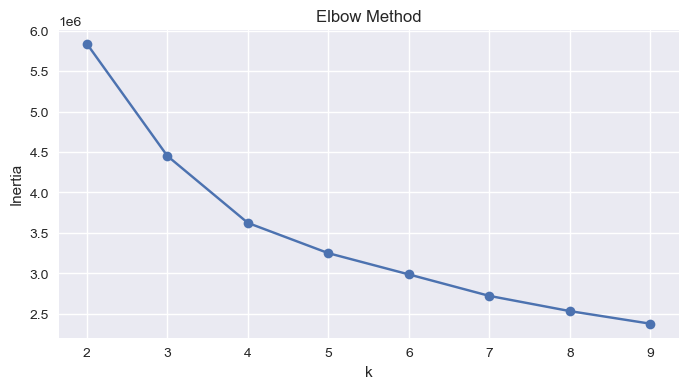

In [44]:
inertias = []
K = range(2, 10)

for k in K:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled)
    inertias.append(km.inertia_)

plt.figure(figsize=(8,4))
plt.plot(K, inertias, marker="o")
plt.title("Elbow Method")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.show()

In [45]:
k = 4
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
df["segment"] = kmeans.fit_predict(X_scaled)
df.head()

,user_id,impressions,clicks,purchases,first_event,last_event,unique_channels,total_events,days_active,recency_days,ctr_ratio,purchase_flag,signup_date,primary_channel,region,ltv_bucket,segment
0,1,1,0,1,2023-12-28 17:00:00,2024-01-01 09:00:00,1,2,4,181,0.0,1,2023-12-28,facebook,LATAM,medium,3
1,2,1,0,1,2023-12-26 13:00:00,2024-01-01 13:00:00,2,2,7,181,0.0,1,2023-12-26,facebook,APAC,medium,3
2,3,1,0,1,2023-12-29 10:00:00,2024-01-01 14:00:00,2,2,4,181,0.0,1,2023-12-29,facebook,EU,high,3
3,4,1,0,1,2023-12-29 09:00:00,2024-01-01 08:00:00,1,2,3,181,0.0,1,2023-12-29,facebook,LATAM,high,3
4,5,0,1,1,2023-12-27 11:00:00,2024-01-01 16:00:00,2,2,6,181,NaN,1,2023-12-27,facebook,APAC,medium,3


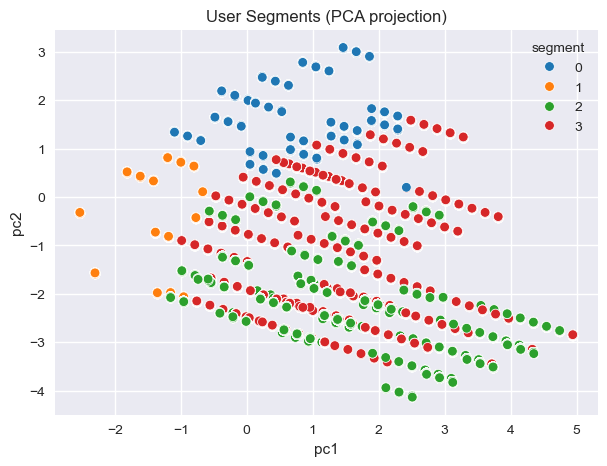

In [46]:
pca = PCA(n_components=2)
pca_coords = pca.fit_transform(X_scaled)

df["pc1"] = pca_coords[:, 0]
df["pc2"] = pca_coords[:, 1]

plt.figure(figsize=(7,5))
sns.scatterplot(data=df, x="pc1", y="pc2", hue="segment", palette="tab10")
plt.title("User Segments (PCA projection)")
plt.show()

In [47]:
segment_profiles = df.groupby("segment")[numeric_cols].mean()
segment_profiles

,impressions,clicks,purchases,total_events,unique_channels,days_active,recency_days,ctr_ratio
segment,,,,,,,,
0,3.308366,0.306200,0.003876,3.618442,2.574693,2.216055,89.851588,0.102067
1,1.254783,0.129481,0.022515,1.406779,1.294490,1.229709,90.368637,0.000000
2,1.449186,1.385775,0.069091,2.904052,2.230228,2.167347,89.867438,1.019240
3,1.436252,0.534481,1.000000,2.970732,2.261641,5.658569,91.329852,0.298310


In [48]:
def label_segment(row):
    if row["segment"] == 0:
        return "Low Engagement"
    elif row["segment"] == 1:
        return "High-Value Buyers"
    elif row["segment"] == 2:
        return "Search-Heavy Explorers"
    elif row["segment"] == 3:
        return "Multi-Channel Browsers"
    else:
        return "Unknown"

df["segment_name"] = df.apply(label_segment, axis=1)

df[["user_id", "segment", "segment_name"]].head()

,user_id,segment,segment_name
0,1,3,Multi-Channel Browsers
1,2,3,Multi-Channel Browsers
2,3,3,Multi-Channel Browsers
3,4,3,Multi-Channel Browsers
4,5,3,Multi-Channel Browsers


In [55]:
df.to_csv("user_segments.csv", index=False)
print("Saved user segments.")

Saved user segments.


**MMM**

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm

plt.style.use("seaborn-v0_8")
sns.set_palette("deep")

raw_path = "data/raw/"

In [64]:
ad = pd.read_csv(raw_path + "ad_spend_by_channel.csv")
sales = pd.read_csv(raw_path + "daily_sales.csv")

ad["date"] = pd.to_datetime(ad["date"])
sales["date"] = pd.to_datetime(sales["date"])

In [66]:
daily = ad.pivot_table(
    index="date",
    columns="channel",
    values="spend",
    aggfunc="sum"
).reset_index()

daily.columns.name = None
daily.head()

,date,email,facebook,search,youtube
0,2024-01-01,486.62,3868.23,4406.67,2091.55
1,2024-01-02,478.12,3455.19,3940.77,2274.76
2,2024-01-03,477.42,4125.32,3530.25,2456.63
3,2024-01-04,601.72,3593.85,5458.76,2804.70
4,2024-01-05,462.37,4052.23,4775.74,2196.81


In [68]:
df = pd.merge(daily, sales, on="date", how="inner")
df.head()

,date,email,facebook,search,youtube,orders,revenue
0,2024-01-01,486.62,3868.23,4406.67,2091.55,1205,103393.47
1,2024-01-02,478.12,3455.19,3940.77,2274.76,1104,96300.58
2,2024-01-03,477.42,4125.32,3530.25,2456.63,1088,79717.07
3,2024-01-04,601.72,3593.85,5458.76,2804.70,1406,106720.86
4,2024-01-05,462.37,4052.23,4775.74,2196.81,1289,101677.30


In [70]:
def adstock(series, decay):
    x = np.zeros(len(series))
    for t in range(len(series)):
        if t == 0:
            x[t] = series.iloc[t]
        else:
            x[t] = series.iloc[t] + decay * x[t-1]
    return x

In [72]:
decay = 0.5  # you can tune this later

for ch in ["facebook", "search", "youtube", "email"]:
    df[ch + "_adstock"] = adstock(df[ch], decay)

In [74]:
for ch in ["facebook", "search", "youtube", "email"]:
    df[ch + "_dr"] = np.log1p(df[ch + "_adstock"])

In [78]:
df.head()

,date,email,facebook,search,youtube,orders,revenue,facebook_adstock,search_adstock,youtube_adstock,email_adstock,facebook_dr,search_dr,youtube_dr,email_dr
0,2024-01-01,486.62,3868.23,4406.67,2091.55,1205,103393.47,3868.230000,4406.670000,2091.550000,486.62000,8.260811,8.391101,7.646139,6.189536
1,2024-01-02,478.12,3455.19,3940.77,2274.76,1104,96300.58,5389.305000,6144.105000,3320.535000,721.43000,8.592357,8.723411,8.108182,6.582621
2,2024-01-03,477.42,4125.32,3530.25,2456.63,1088,79717.07,6819.972500,6602.302500,4116.897500,838.13500,8.827757,8.795325,8.323098,6.732372
3,2024-01-04,601.72,3593.85,5458.76,2804.70,1406,106720.86,7003.836250,8759.911250,4863.148750,1020.78750,8.854356,9.078055,8.489647,6.929309
4,2024-01-05,462.37,4052.23,4775.74,2196.81,1289,101677.30,7554.148125,9155.695625,4628.384375,972.76375,8.929984,9.122241,8.440179,6.881169


In [76]:
y = df["revenue"]
X = df[[ch + "_dr" for ch in ["facebook", "search", "youtube", "email"]]]

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.358
Model:                            OLS   Adj. R-squared:                  0.343
Method:                 Least Squares   F-statistic:                     24.40
Date:                Sat, 22 Nov 2025   Prob (F-statistic):           4.66e-16
Time:                        11:27:29   Log-Likelihood:                -1958.1
No. Observations:                 180   AIC:                             3926.
Df Residuals:                     175   BIC:                             3942.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -6.474e+05    8.8e+04     -7.360      0.000   -8.21e+05   -4.74e+05
facebook_dr  2.027e+04   1.05e+04      1.923      0.056    -538.646    4.11e+04
search_dr    6.564e+04   9026.940      7.271      0.000    4.78e+04    8.35e+04
youtube_dr   1053.0307   1.04e+04      0.101      0.920   -1.95e+04    2.16e+04
email_dr    -6062.9819   1.12e+04     -0.540      0.590   -2.82e+04    1.61e+04
==============================================================================
Omnibus:                       35.040   Durbin-Watson:                   1.894
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               74.897
Skew:                           0.883   Prob(JB):                     5.45e-17
Kurtosis:                       5.621   Cond. No.                     1.54e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.54e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

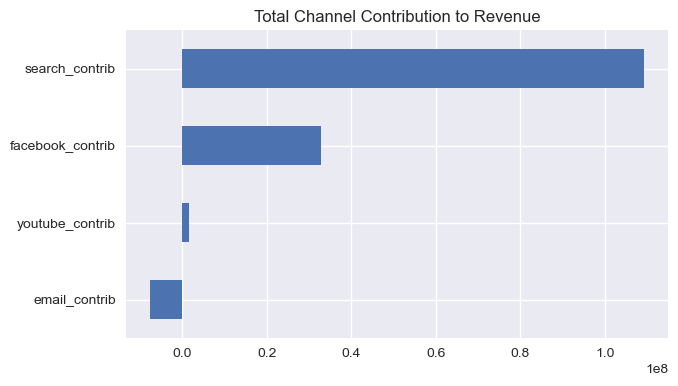

In [80]:
df["y_pred"] = model.predict(X)

for ch in ["facebook", "search", "youtube", "email"]:
    df[ch + "_contrib"] = model.params[ch + "_dr"] * df[ch + "_dr"]


channel_contrib = df[[ch + "_contrib" for ch in ["facebook", "search", "youtube", "email"]]].sum()
channel_contrib

channel_contrib.sort_values().plot(kind="barh", figsize=(7,4))
plt.title("Total Channel Contribution to Revenue")
plt.show()

In [92]:
df["y_pred"]

0       41359.449560
1       67995.221230
2       76805.325475
3       94883.749871
4       99556.730249
           ...      
175    108777.638150
176     97385.231776
177    104181.501211
178    109775.816842
179    109586.834010
Name: y_pred, Length: 180, dtype: float64

Total spend:
channel
facebook    743497.07
search      935761.11
youtube     462673.85
email        95188.02
Name: spend, dtype: float64

Channel contribution (incremental revenue):
facebook    3.286206e+07
search      1.091238e+08
youtube     1.617543e+06
email      -7.589702e+06
dtype: float64

ROI (incremental revenue per $1 spent):
facebook     44.199309
search      116.615070
youtube       3.496077
email       -79.733796
dtype: float64


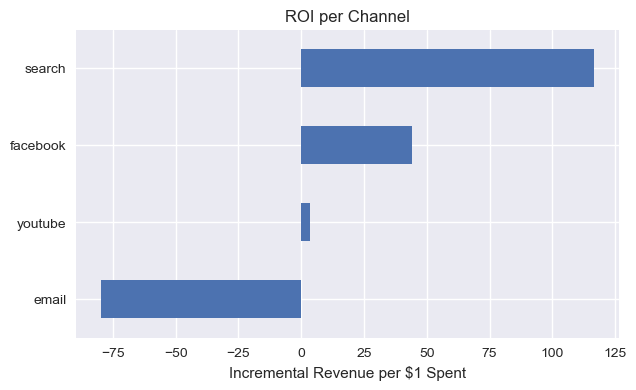

In [96]:
# List of channels used in the model
channels = ["facebook", "search", "youtube", "email"]

# 1) Total spend per channel over the whole period
total_spend = (
    ad.groupby("channel")["spend"]
      .sum()
      .reindex(channels)
)

# 2) Total incremental revenue contribution per channel from MMM
channel_contrib = pd.Series(
    {ch: df[f"{ch}_contrib"].sum() for ch in channels}
)

print("Total spend:")
print(total_spend)
print("\nChannel contribution (incremental revenue):")
print(channel_contrib)

# 3) ROI = incremental revenue / spend
roi = channel_contrib / total_spend

print("\nROI (incremental revenue per $1 spent):")
print(roi)

# 4) Plot
roi.sort_values().plot(kind="barh", figsize=(7,4))
plt.title("ROI per Channel")
plt.xlabel("Incremental Revenue per $1 Spent")
plt.show()

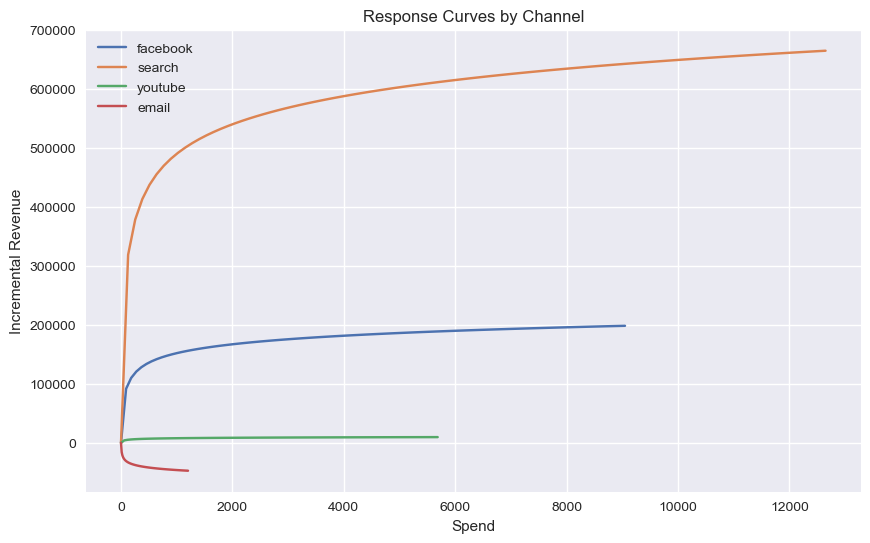

In [84]:
response_curves = {}

for ch in ["facebook", "search", "youtube", "email"]:
    spend_range = np.linspace(0, df[ch].max()*1.5, 100)
    adstock_vals = adstock(pd.Series(spend_range), decay)
    dr_vals = np.log1p(adstock_vals)
    
    # predicted incremental
    pred = model.params[ch + "_dr"] * dr_vals
    
    response_curves[ch] = (spend_range, pred)


plt.figure(figsize=(10,6))
for ch, (spend_range, pred) in response_curves.items():
    plt.plot(spend_range, pred, label=ch)
plt.legend()
plt.title("Response Curves by Channel")
plt.xlabel("Spend")
plt.ylabel("Incremental Revenue")
plt.show()

In [90]:
df.to_csv("mmm_outputs.csv", index=False)
roi.to_csv("channel_roi.csv")
channel_contrib.to_csv("channel_contrib.csv")

print("MMM results saved.")

MMM results saved.


Marketing Mix Modeling (MMM) — Summary of What We Did

Data Preparation
	•	Loaded daily channel-level spend and daily revenue data.
	•	Pivoted data so each day has spend columns for: facebook, search, youtube, email.
	•	Merged the channel spend data with daily revenue to form the MMM dataset.

Adstock Transformation (Carryover Effect)
	•	Implemented geometric adstock to model how ad effects persist across days.
	•	Created new variables like facebook_adstock, search_adstock, etc.
	•	Purpose: simulate memory effect in consumer behavior.
	•	Carryover effect
	•	Lagged impact
	•	Adstock decay

Diminishing Returns (Nonlinear Saturation)
	•	Applied log1p (log(1+x)) transformation to adstock variables.
	•	This models the fact that incremental ROI declines as spend increases.
	•	Created variables like facebook_dr representing diminished-response media inputs.
	•	Saturation
	•	Diminishing returns
	•	Concave response function

OLS Regression Model (Stage 1 MMM)
	•	Built the MMM using statsmodels OLS (Ordinary Least Squares).
	•	Used sm.add_constant() to include intercept (baseline sales).
	•	Extracted:
	•	Coefficients (effect sizes)
	•	p-values (significance)
	•	R² (model fit)
	•	Standard errors, CI, diagnostics
	•	OLS regression
	•	Intercept
	•	Coefficient
	•	Significance
	•	Baseline sales


Channel Contribution Calculation
	•	Multiplied each channel’s:
	•	Coefficient (β) × Transformed spend value
	•	Produced daily incremental revenue contributions like:
	•	facebook_contrib
	•	search_contrib
	•	Summed them to quantify each channel’s total contribution over the period.
	•	Incremental contribution
	•	Channel lift
	•	Attribution via MMM coefficients

ROI Calculation (Return on Investment)
	•	Computed total spend per channel.
	•	Calculated ROI = contribution / spend for each channel.
	•	Interpreted ROI to determine which channels are:
	•	Under-spent
	•	Efficient
	•	Inefficient
	•	Incremental ROI
	•	Marginal ROI
	•	Spend efficiency

Response Curve Construction
	•	Simulated hypothetical spend levels for each channel.
	•	Re-applied adstock + log transform to those values.
	•	Multiplied by channel coefficients to compute predicted revenue.
	•	Graphed response curves (spend → revenue curves).
	•	Response function
	•	Saturation curve
	•	Hypothetical scenarios
	•	Model-based simulation

**media Optimization**

In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

plt.style.use("seaborn-v0_8")

df = pd.read_csv("mmm_outputs.csv")

channels = ["facebook", "search", "youtube", "email"]

def adstock(values, decay=0.5):
    x = np.zeros(len(values))
    for t in range(len(values)):
        if t == 0:
            x[t] = values[t]
        else:
            x[t] = values[t] + decay * x[t - 1]
    return x

def transform_media(spend, decay=0.5):
    adstock_vals = adstock(spend, decay)
    return np.log1p(adstock_vals)

In [107]:
import statsmodels.api as sm

# Rebuild X for model so we can reload the model parameters
X_cols = [ch + "_dr" for ch in channels]
X = df[X_cols]
X = sm.add_constant(X)

y = df["revenue"]

# Fit the same OLS model again (safe because all data is same)
model = sm.OLS(y, X).fit()
model.params

const         -647384.466917
facebook_dr     20269.358536
search_dr       65638.344353
youtube_dr       1053.030715
email_dr        -6062.981867
dtype: float64

In [109]:
def predict_revenue_from_spend(spends, decay=0.5):
    transformed = []

    for spend, ch in zip(spends, channels):
        # Simulate a single spend level repeated (adstock needs a sequence)
        spend_series = pd.Series([spend])
        val = transform_media(spend_series, decay)[0]
        transformed.append(val)

    transformed = np.array(transformed)

    # β0 + Σ(β_i * channel_i)
    revenue_pred = model.params["const"] + np.sum(
        model.params[[ch + "_dr" for ch in channels]].values * transformed
    )

    return revenue_pred

In [111]:
def objective(spends):
    return -predict_revenue_from_spend(spends)

In [113]:
current_total_spend = df[channels].mean().sum()
budget = current_total_spend

budget

12428.444722222222

In [115]:
constraints = ({
    "type": "eq",
    "fun": lambda spends: np.sum(spends) - budget
})

In [117]:
bounds = [(0, None) for _ in channels]

In [119]:
initial_spend = np.ones(len(channels)) * (budget / len(channels))
initial_spend

array([3107.11118056, 3107.11118056, 3107.11118056, 3107.11118056])

In [121]:
result = minimize(
    objective,
    initial_spend,
    bounds=bounds,
    constraints=constraints,
    method="SLSQP",
)

result

 message: Positive directional derivative for linesearch
 success: False
  status: 8
     fun: -119849.06902597554
       x: [ 2.898e+03  9.381e+03  1.494e+02  0.000e+00]
     nit: 38
     jac: [-6.992e+00 -7.000e+00 -7.000e+00  6.063e+03]
    nfev: 252
    njev: 34

In [123]:
optimized_spend = result.x
optimized_spend

array([2897.70765698, 9381.29120321,  149.44587771,    0.        ])

In [125]:
comparison = pd.DataFrame({
    "channel": channels,
    "current_avg_spend": df[channels].mean().values,
    "optimal_spend": optimized_spend
})

comparison["difference"] = comparison["optimal_spend"] - comparison["current_avg_spend"]

comparison

,channel,current_avg_spend,optimal_spend,difference
0,facebook,4130.539278,2897.707657,-1232.831621
1,search,5198.672833,9381.291203,4182.618370
2,youtube,2570.410278,149.445878,-2420.964400
3,email,528.822333,0.000000,-528.822333


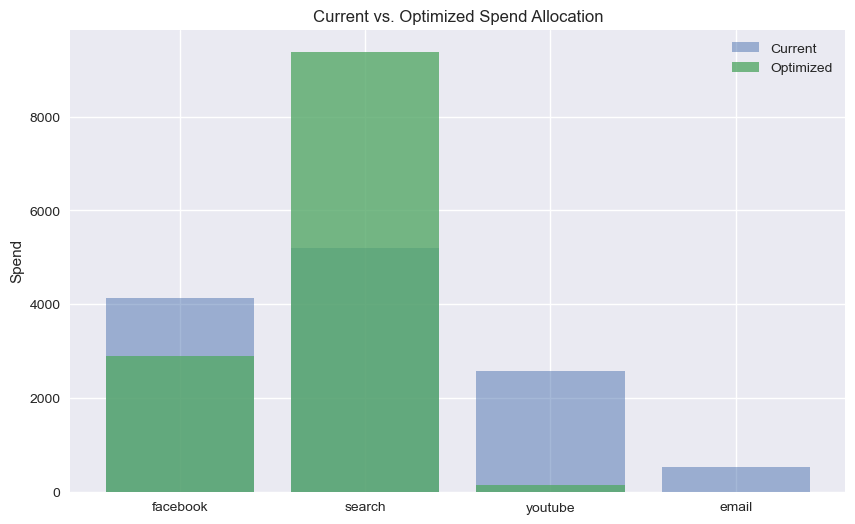

In [127]:
plt.figure(figsize=(10,6))
plt.bar(comparison["channel"], comparison["current_avg_spend"], alpha=0.5, label="Current")
plt.bar(comparison["channel"], comparison["optimal_spend"], alpha=0.8, label="Optimized")
plt.title("Current vs. Optimized Spend Allocation")
plt.ylabel("Spend")
plt.legend()
plt.show()

In [129]:
current_pred = predict_revenue_from_spend(df[channels].mean().values)
optimized_pred = predict_revenue_from_spend(optimized_spend)

print("Current predicted revenue:", current_pred)
print("Optimized predicted revenue:", optimized_pred)
print("Lift (%):", (optimized_pred - current_pred) / current_pred * 100)

Current predicted revenue: 53249.45161654393
Optimized predicted revenue: 119849.06902597554
Lift (%): 125.07099207147508


**MTV**

In [135]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8")
sns.set_palette("deep")

raw_path = "data/raw/"
proc_path = "data/processed/"

events = pd.read_csv(raw_path + "user_events.csv")
events["event_time"] = pd.to_datetime(events["event_time"])

events.head()

,user_id,event_time,event_type,channel
0,1,2023-12-28 17:00:00,impression,facebook
1,1,2024-01-01 09:00:00,purchase,facebook
2,2,2023-12-26 13:00:00,impression,youtube
3,2,2024-01-01 13:00:00,purchase,facebook
4,3,2023-12-29 10:00:00,impression,search


In [137]:
print(events["event_type"].value_counts())
print(events["channel"].value_counts())
events.sort_values(["user_id", "event_time"]).head(10)



event_type
impression    1797512
click          509813
purchase       242846
Name: count, dtype: int64
channel
search      717510
email       624205
facebook    618664
youtube     589792
Name: count, dtype: int64


,user_id,event_time,event_type,channel
0,1,2023-12-28 17:00:00,impression,facebook
1,1,2024-01-01 09:00:00,purchase,facebook
2,2,2023-12-26 13:00:00,impression,youtube
3,2,2024-01-01 13:00:00,purchase,facebook
4,3,2023-12-29 10:00:00,impression,search
5,3,2024-01-01 14:00:00,purchase,facebook
6,4,2023-12-29 09:00:00,impression,facebook
7,4,2024-01-01 08:00:00,purchase,facebook
8,5,2023-12-27 11:00:00,click,youtube
9,5,2024-01-01 16:00:00,purchase,facebook


In [139]:
# First purchase time per user
first_purchase = (
    events[events["event_type"] == "purchase"]
    .groupby("user_id", as_index=False)["event_time"]
    .min()
    .rename(columns={"event_time": "first_purchase_time"})
)

len(first_purchase), first_purchase.head()

(242846,
    user_id first_purchase_time
 0        1 2024-01-01 09:00:00
 1        2 2024-01-01 13:00:00
 2        3 2024-01-01 14:00:00
 3        4 2024-01-01 08:00:00
 4        5 2024-01-01 16:00:00)

In [141]:
# Merge first purchase time into events
events_merged = events.merge(first_purchase, on="user_id", how="left")

# Keep only converting users
conv_events = events_merged[~events_merged["first_purchase_time"].isna()].copy()

# Keep events up to first purchase
conv_events = conv_events[
    conv_events["event_time"] <= conv_events["first_purchase_time"]
].copy()

conv_events.sort_values(["user_id", "event_time"]).head(15)

,user_id,event_time,event_type,channel,first_purchase_time
0,1,2023-12-28 17:00:00,impression,facebook,2024-01-01 09:00:00
1,1,2024-01-01 09:00:00,purchase,facebook,2024-01-01 09:00:00
2,2,2023-12-26 13:00:00,impression,youtube,2024-01-01 13:00:00
3,2,2024-01-01 13:00:00,purchase,facebook,2024-01-01 13:00:00
4,3,2023-12-29 10:00:00,impression,search,2024-01-01 14:00:00
5,3,2024-01-01 14:00:00,purchase,facebook,2024-01-01 14:00:00
6,4,2023-12-29 09:00:00,impression,facebook,2024-01-01 08:00:00
7,4,2024-01-01 08:00:00,purchase,facebook,2024-01-01 08:00:00
8,5,2023-12-27 11:00:00,click,youtube,2024-01-01 16:00:00
9,5,2024-01-01 16:00:00,purchase,facebook,2024-01-01 16:00:00


In [143]:
def build_channel_path(group):
    # Sort by time
    group = group.sort_values("event_time")
    # Keep only events that are touchpoints (we can include purchase channel as last)
    channels = group["channel"].tolist()
    return channels

paths = (
    conv_events
    .groupby("user_id")
    .apply(build_channel_path)
    .reset_index(name="path")
)

paths.head()
print("Example path:", paths["path"].iloc[0])
print("Number of converting users:", len(paths))

Example path: ['facebook', 'facebook']
Number of converting users: 242846


/var/folders/l5/tffrmfjn0nz2c3_lnvvkvh500000gn/T/ipykernel_33346/377002337.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(build_channel_path)


In [ ]:
from collections import Counter

def attrib_last_touch(path):
    """100% credit to the last channel."""
    if not path:
        return {}
    last = path[-1]
    return {last: 1.0}

def attrib_first_touch(path):
    """100% credit to the first channel."""
    if not path:
        return {}
    first = path[0]
    return {first: 1.0}

def attrib_linear(path):
    """Equal credit to all touchpoints in the path."""
    if not path:
        return {}
    n = len(path)
    credit = 1.0 / n
    counts = Counter(path)
    # If the same channel appears multiple times, it accumulates
    return {ch: count * credit for ch, count in counts.items()}

def attrib_position_based_40_40_20(path):
    """
    40% to first, 40% to last, 20% distributed equally across middle touches.
    If only 1 touch → 100% to that.
    If 2 touches → 50/50.
    """
    if not path:
        return {}
    if len(path) == 1:
        return {path[0]: 1.0}
    if len(path) == 2:
        # Split evenly
        return {path[0]: 0.5, path[1]: 0.5}
    
    first = path[0]
    last = path[-1]
    middle = path[1:-1]
    
    credits = Counter()
    credits[first] += 0.4
    credits[last] += 0.4
    
    if middle:
        mid_share = 0.2 / len(middle)
        for ch in middle:
            credits[ch] += mid_share
    
    return dict(credits)

In [147]:
channels = ["facebook", "search", "youtube", "email"]

methods = {
    "last_touch": attrib_last_touch,
    "first_touch": attrib_first_touch,
    "linear": attrib_linear,
    "position_40_40_20": attrib_position_based_40_40_20,
}

# Initialize counters
attrib_results = {
    name: Counter() for name in methods.keys()
}

# Loop over each converting user path
for _, row in paths.iterrows():
    path = row["path"]
    for name, func in methods.items():
        contrib = func(path)
        attrib_results[name].update(contrib)

attrib_results

{'last_touch': Counter({'search': 140682.0,
          'email': 47534.0,
          'facebook': 42069.0,
          'youtube': 12561.0}),
 'first_touch': Counter({'search': 60886.0,
          'email': 60835.0,
          'facebook': 60563.0,
          'youtube': 60562.0}),
 'linear': Counter({'search': 89689.41666665544,
          'email': 55934.250000016866,
          'facebook': 53914.250000015876,
          'youtube': 43308.08333333893}),
 'position_40_40_20': Counter({'search': 89588.69999998169,
          'email': 53014.000000002336,
          'facebook': 50833.300000000294,
          'youtube': 39270.999999999534})}

In [149]:
rows = []

for method_name, counter in attrib_results.items():
    total = sum(counter.values())  # total credited conversions (should equal #conversions)
    for ch in channels:
        val = counter.get(ch, 0.0)
        share = val / total if total > 0 else 0.0
        rows.append({
            "method": method_name,
            "channel": ch,
            "conversions_attributed": val,
            "share": share,
        })

attrib_df = pd.DataFrame(rows)
attrib_df

,method,channel,conversions_attributed,share
0,last_touch,facebook,42069.000000,0.173233
1,last_touch,search,140682.000000,0.579305
2,last_touch,youtube,12561.000000,0.051724
3,last_touch,email,47534.000000,0.195737
4,first_touch,facebook,60563.000000,0.249389
5,first_touch,search,60886.000000,0.250719
6,first_touch,youtube,60562.000000,0.249384
7,first_touch,email,60835.000000,0.250509
8,linear,facebook,53914.250000,0.222010
9,linear,search,89689.416667,0.369326


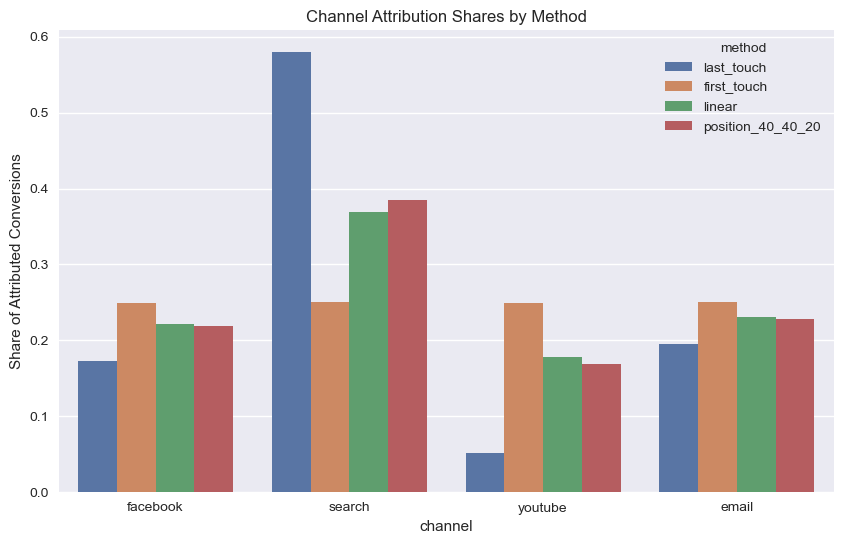

In [151]:
plt.figure(figsize=(10,6))
sns.barplot(
    data=attrib_df,
    x="channel",
    y="share",
    hue="method"
)
plt.title("Channel Attribution Shares by Method")
plt.ylabel("Share of Attributed Conversions")
plt.show()

In [167]:
channels = ["facebook", "search", "youtube", "email"]

# Load MMM contributions
mmm_contrib = pd.read_csv("channel_contrib.csv", header=None, names=["channel", "contribution"])

# Drop the NaN row
mmm_contrib = mmm_contrib.dropna(subset=["channel"])

# Strip the "_contrib" suffix to get clean channel names
mmm_contrib["channel"] = mmm_contrib["channel"].str.replace("_contrib", "", regex=False)

# Set index to clean channel name
mmm_contrib = mmm_contrib.set_index("channel")["contribution"]

# Normalize to shares and align with our channels list
mmm_share = (mmm_contrib / mmm_contrib.sum()).reindex(channels)

mmm_share

channel
facebook    0.241608
search      0.802300
youtube     0.011892
email      -0.055801
Name: contribution, dtype: float64

In [169]:
# Pick one MTA method to compare (e.g., last_touch)
last_touch_shares = (
    attrib_df[attrib_df["method"] == "last_touch"]
    .set_index("channel")["share"]
    .reindex(channels)
)

comparison = pd.DataFrame({
    "MMM_share": mmm_share,
    "MTA_last_touch_share": last_touch_shares,
})

comparison

,MMM_share,MTA_last_touch_share
channel,,
facebook,0.241608,0.173233
search,0.802300,0.579305
youtube,0.011892,0.051724
email,-0.055801,0.195737


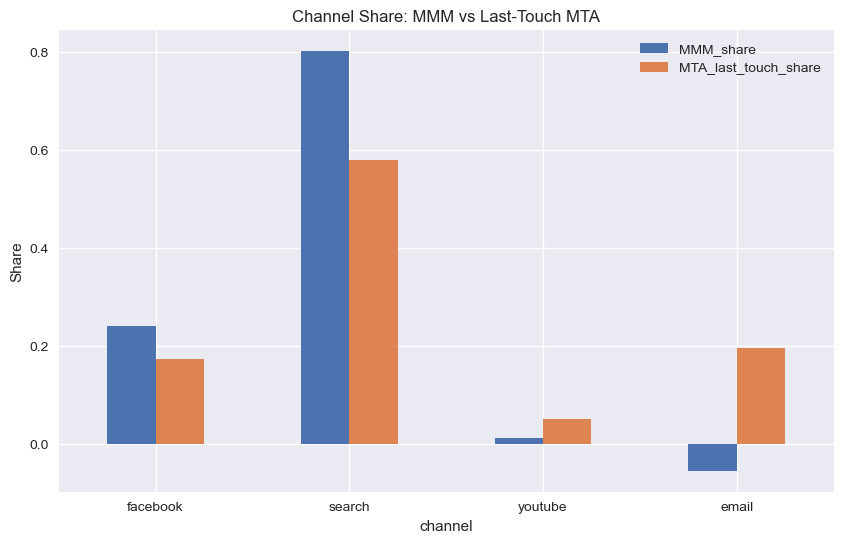

In [171]:
comparison.plot(kind="bar", figsize=(10,6))
plt.title("Channel Share: MMM vs Last-Touch MTA")
plt.ylabel("Share")
plt.xticks(rotation=0)
plt.show()

In [173]:
attrib_df.to_csv("mta_attribution_results.csv", index=False)
comparison.to_csv("mmm_vs_mta_comparison.csv")
print("Saved MTA and MMM vs MTA comparison results.")

Saved MTA and MMM vs MTA comparison results.


**Summary of MTA**

	•	Loaded and cleaned the raw user_events.csv dataset
	•	Converted timestamps and inspected event types and channels
	•	Identified converting users and extracted each user’s first purchase timestamp
	•	Filtered events to keep only pre-purchase touchpoints
	•	Built ordered customer journeys (channel paths) per user
	•	Implemented four attribution models:
	•	Last-touch
	•	First-touch
	•	Linear
	•	Position-based (40-40-20)
	•	Applied all four attribution methods to every user journey
	•	Aggregated channel-level credit for each attribution model
	•	Converted results to a structured DataFrame with:
	•	channel
	•	attributed conversions
	•	share of conversions
	•	Visualized attribution results across methods using a bar chart
	•	Loaded MMM results and compared MMM vs MTA channel shares
	•	Saved attribution outputs for downstream reporting
